In [1]:
!pip install xgboost==3.0.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler

In [3]:
def scale_in_blocks_aligned(X: pd.DataFrame, y: pd.Series, block_size: int):
    scaler = MinMaxScaler()

    n = len(X)
    n_blocks = n // block_size  # blocos completos

    scaled_blocks = []
    y_blocks = []

    for i in range(n_blocks):
        start = i * block_size
        end = start + block_size

        # pega o bloco X e y
        X_block = X.iloc[start:end].copy()
        y_block = y.iloc[start:end].copy()

        # normaliza o bloco X
        X_scaled = pd.DataFrame(scaler.fit_transform(X_block),
                                columns=X.columns,
                                index=X_block.index)

        scaled_blocks.append(X_scaled)
        y_blocks.append(y_block)

    # concatena todos os blocos normalizados e y alinhado
    X_scaled_full = pd.concat(scaled_blocks)
    y_aligned = pd.concat(y_blocks)

    return X_scaled_full, y_aligned

#Carregamento DF-ONChain

In [4]:
df_onchain = pd.read_csv('/content/database_rotulado.csv')

In [5]:
df_onchain = df_onchain.drop(['label'],axis=1)

In [6]:
df_onchain.head()

,timestamp,Open,High,Low,Close,volume,marketCap,weight_mean,difficulty_mean,reward_mean,total_of_transactions,total_of_witness,total_input,total_output,total_fees
0,2010-07-14,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,11388.193772,45.385822,5.000002e+09,6132.0,0.0,6743.0,11468.0,1000000.0
1,2010-07-15,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,3489.185897,45.385822,5.000106e+09,1330.0,0.0,2802.0,1797.0,66000000.0
2,2010-07-16,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,2447.271287,62.371803,5.000053e+09,1181.0,0.0,1474.0,1616.0,27000000.0
3,2010-07-17,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,2922.612717,181.543289,5.000029e+09,408.0,0.0,674.0,550.0,5000000.0
4,2010-07-18,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,3385.139535,181.543289,5.000483e+09,420.0,0.0,784.0,572.0,83000000.0


#Inner Joins

In [7]:
dataset_exemplo = pd.read_csv('/content/clean_sentiment.csv')

In [8]:
dataset_exemplo.head()

,Date,Gênero,Number_Sentments
0,2014-09-18,Negative,1
1,2014-09-19,Negative,1
2,2014-09-20,Positive,2
3,2014-09-21,Negative,1
4,2014-09-22,Positive,2


In [9]:
dataset_exemplo.columns

Index(['Date', 'Gênero', 'Number_Sentments'], dtype='object')

In [10]:
df_onchain['timestamp'] = pd.to_datetime(df_onchain['timestamp'], format='%Y-%m-%d')
dataset_exemplo['Date'] = pd.to_datetime(dataset_exemplo['Date'], format='%Y-%m-%d')

In [11]:
df_final = pd.merge(
    dataset_exemplo,
    df_onchain,
    left_on='Date',
    right_on='timestamp',
    how='inner'
)

In [12]:
df_final = df_final.drop(['Gênero'],axis=1)

In [13]:
df_final.head()

,Date,Number_Sentments,timestamp,Open,High,Low,Close,volume,marketCap,weight_mean,difficulty_mean,reward_mean,total_of_transactions,total_of_witness,total_input,total_output,total_fees
0,2014-09-18,1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,5.638919e+09,9.468118e+05,2.982973e+10,2.506898e+09,77364.0,0.0,208697.0,221458.0,1.234660e+09
1,2014-09-19,1,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,5.246780e+09,8.854114e+05,2.982973e+10,2.506205e+09,69437.0,0.0,186961.0,190782.0,1.061079e+09
2,2014-09-20,2,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,5.436072e+09,8.336068e+05,2.982973e+10,2.505833e+09,63482.0,0.0,180628.0,189403.0,1.026634e+09
3,2014-09-21,1,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,5.303651e+09,8.719851e+05,2.982973e+10,2.505693e+09,59800.0,0.0,159698.0,265820.0,9.337163e+08
4,2014-09-22,2,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,5.349637e+09,1.041553e+06,2.982973e+10,2.506973e+09,73289.0,0.0,216833.0,226209.0,1.171465e+09


#Machine Learning

In [14]:
df_copy = df_final.copy()

In [15]:
df_final = df_final.loc[df_final['Number_Sentments'] != 0]

In [16]:
# Substituindo os valores diretamente
df_final['Number_Sentments'] = df_final['Number_Sentments'].replace({1: 0, 2: 1})


In [17]:
df_final = df_final.iloc[::-1].reset_index(drop=True)

In [18]:
X = df_final.drop(['timestamp','Date','Number_Sentments'],axis=1)
y = df_final['Number_Sentments']

In [19]:
# Supondo que o seu dataframe seja chamado df e a coluna de interesse seja 'classe'
proporcao_classes = y.value_counts(normalize=True)

# Exibe a proporção de cada classe
print(proporcao_classes)

Number_Sentments
1    0.546512
0    0.453488
Name: proportion, dtype: float64


In [20]:
len(X.columns)

14

In [21]:
X, y = scale_in_blocks_aligned(X, y, 30)

In [22]:
y.unique()

array([1, 0])


🔍 Avaliando Logistic Regression com K-Fold...
  Fold 1: F1-Score = 0.8488
  Fold 2: F1-Score = 0.8986
  Fold 3: F1-Score = 0.8703
  Fold 4: F1-Score = 0.8894
  Fold 5: F1-Score = 0.8757
→ Média de F1-Score: 0.8765 | Desvio padrão: 0.0171

🔍 Avaliando KNN com K-Fold...
  Fold 1: F1-Score = 0.6429
  Fold 2: F1-Score = 0.6450
  Fold 3: F1-Score = 0.6529
  Fold 4: F1-Score = 0.7217
  Fold 5: F1-Score = 0.6667
→ Média de F1-Score: 0.6658 | Desvio padrão: 0.0292

🔍 Avaliando SVC com K-Fold...
  Fold 1: F1-Score = 0.8000
  Fold 2: F1-Score = 0.8264
  Fold 3: F1-Score = 0.8497
  Fold 4: F1-Score = 0.8434
  Fold 5: F1-Score = 0.7731
→ Média de F1-Score: 0.8185 | Desvio padrão: 0.0285

🔍 Avaliando Naive Bayes com K-Fold...
  Fold 1: F1-Score = 0.6962
  Fold 2: F1-Score = 0.7187
  Fold 3: F1-Score = 0.7468
  Fold 4: F1-Score = 0.7540
  Fold 5: F1-Score = 0.6830
→ Média de F1-Score: 0.7197 | Desvio padrão: 0.0276

🔍 Avaliando MLP com K-Fold...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 1: F1-Score = 0.8346


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 2: F1-Score = 0.8549


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 3: F1-Score = 0.8368


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 4: F1-Score = 0.8879


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Fold 5: F1-Score = 0.8401
→ Média de F1-Score: 0.8509 | Desvio padrão: 0.0198

🔍 Avaliando Random Forest com K-Fold...
  Fold 1: F1-Score = 0.8199
  Fold 2: F1-Score = 0.8687
  Fold 3: F1-Score = 0.8119
  Fold 4: F1-Score = 0.8703
  Fold 5: F1-Score = 0.8120
→ Média de F1-Score: 0.8366 | Desvio padrão: 0.0271

🔍 Avaliando Gradient Boosting com K-Fold...
  Fold 1: F1-Score = 0.8393
  Fold 2: F1-Score = 0.8662
  Fold 3: F1-Score = 0.8479
  Fold 4: F1-Score = 0.8802
  Fold 5: F1-Score = 0.8435
→ Média de F1-Score: 0.8554 | Desvio padrão: 0.0154

🔍 Avaliando XGBoost com K-Fold...
  Fold 1: F1-Score = 0.8366


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: F1-Score = 0.8778


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3: F1-Score = 0.8390
  Fold 4: F1-Score = 0.9139


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5: F1-Score = 0.8447
→ Média de F1-Score: 0.8624 | Desvio padrão: 0.0297


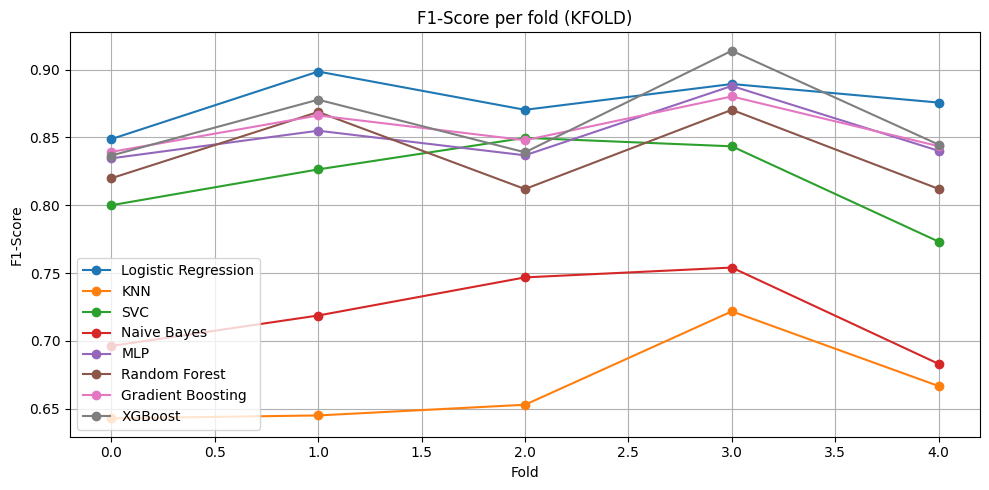


Modelos ordenados por F1-Score:
Logistic Regression: 0.8765
XGBoost: 0.8624
Gradient Boosting: 0.8554
MLP: 0.8509
Random Forest: 0.8366
SVC: 0.8185
Naive Bayes: 0.7197
KNN: 0.6658


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import f1_score

# === Modelos ===
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# === Validação Cruzada Temporal ===
tscv = KFold(n_splits=5)
resultados = {}
mean_scores = {}

for nome, modelo in modelos.items():
    print(f'\n🔍 Avaliando {nome} com K-Fold...')

    # Lista para armazenar scores (precision class 1) por fold
    scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Separar dados com .iloc para evitar KeyError
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        # Normalização sem vazamento
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Treinar modelo
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Calcular a precisão para a classe 1
        score = f1_score(y_test, y_pred)
        scores.append(score)

        print(f'  Fold {fold+1}: F1-Score = {score:.4f}')

    # Calcular a média e desvio padrão da precisão da classe 1
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    print(f'→ Média de F1-Score: {mean_score:.4f} | Desvio padrão: {std_score:.4f}')

    # Armazenar os resultados
    resultados[nome] = scores
    mean_scores[nome] = mean_score

# === Visualização dos Resultados ===
plt.figure(figsize=(10, 5))

# Plotando os scores de precisão para cada modelo
for nome, scores in resultados.items():
    plt.plot(scores, marker='o', label=nome)

plt.title("F1-Score per fold (KFOLD)")
plt.xlabel("Fold")
plt.ylabel("F1-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Salvar gráfico em formato SVG
plt.savefig('cross_validation_timeseries_results.svg', dpi=300)

plt.show()

# === Ordenando os Modelos com base na Média da Precision da Classe 1 ===
print("\nModelos ordenados por F1-Score:")
for nome, score in sorted(mean_scores.items(), key=lambda item: item[1], reverse=True):
    print(f'{nome}: {score:.4f}')


In [24]:
len(X)

1890

In [25]:
len(y)

1890

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Vamos supor que X_real e y_real já estão prontos
# Divisão em dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
import xgboost as xgb
print(xgb.__version__)


3.0.0


In [28]:
# Criar o modelo XGBoost com os parâmetros solicitados
model = xgb.XGBClassifier(
    use_label_encoder=False,   # Desativa o uso do label encoder
    eval_metric='mlogloss',    # Define o critério de avaliação como mlogloss (entropia cruzada)
    random_state=42            # Define a semente para garantir reprodutibilidade
)

# Treinar o modelo
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
y_pred = model.predict(X_test)

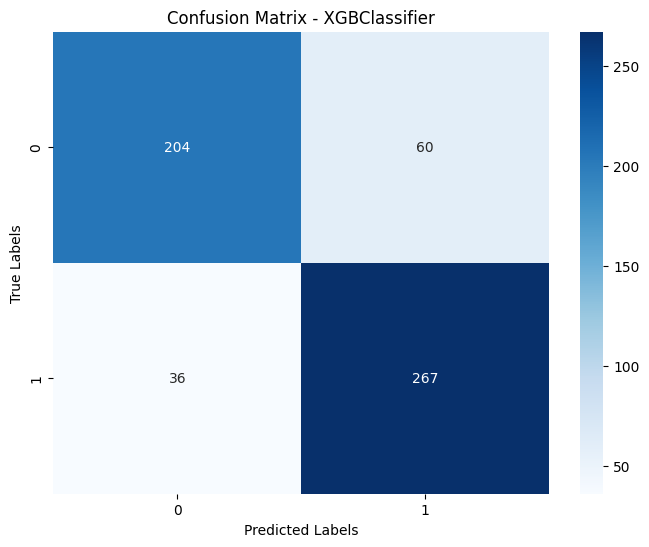

In [30]:
# Gerando a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotando a Confusion Matrix usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBClassifier')

plt.savefig('confusion_matrix_lr.svg', dpi=300)

plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# Calculando as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibindo as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.8307
Precisão: 0.8165
Recall: 0.8812
F1-Score: 0.8476


# SHAP Test


In [32]:
!pip install shap

In [33]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)



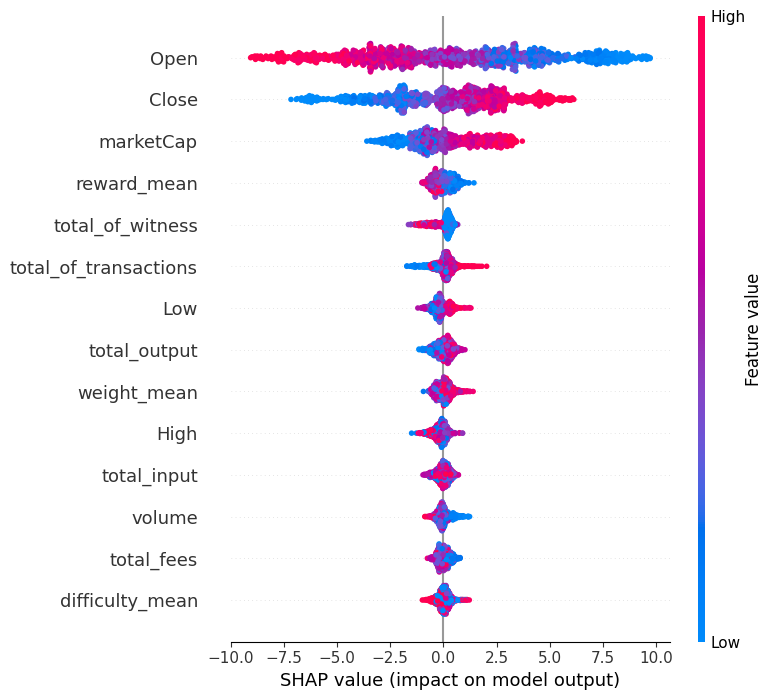

In [44]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_train, feature_names=features, show=False)

plt.savefig('shap_results.svg', dpi=300)

plt.show()
